In [1]:
import sys
import os
parent_dir = os.path.dirname(os.getcwd())
sys.path.insert(0, parent_dir)
import src

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import tensorflow as tf
from tensorflow import keras
import glob

We can take our preprocessed data, chunk it into smaller bits of data -- like 2min or something -- then use resampling to generate fixed-length signals that can be fed into an LSTM.

In [2]:
random_file = np.random.choice(glob.glob('../data/preprocessed/*'))
print(random_file)
df = pd.read_csv(random_file, index_col='ptime')
df.index = pd.to_timedelta(df.index)
df = src.features.extend(df, src.features.extending.inter_arrival_time)
resampled = df.resample('100ms').sum().reset_index()
slice_indices = np.argwhere(
    resampled.ptime.isin(
        pd.timedelta_range(resampled.ptime.min(), resampled.ptime.max(), freq='90s')
    )
    .values
).ravel()
chunks = np.split(resampled, slice_indices)[1:-1]

../data/preprocessed/browsing-apristin-novideo-vpn-windows-20201109-0.csv


<AxesSubplot:>

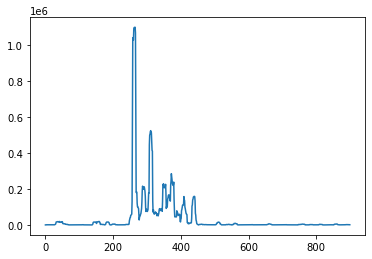

In [3]:
signal = chunks[0].rolling('1s', on='ptime').psize.sum()
signal.plot()

In [4]:
tuple(signal.values)

(118.0,
 118.0,
 118.0,
 778.0,
 778.0,
 778.0,
 778.0,
 778.0,
 778.0,
 1148.0,
 1030.0,
 1030.0,
 1030.0,
 613.0,
 613.0,
 613.0,
 613.0,
 900.0,
 900.0,
 530.0,
 530.0,
 530.0,
 530.0,
 287.0,
 287.0,
 287.0,
 287.0,
 816.0,
 1935.0,
 3491.0,
 4069.0,
 11060.0,
 16621.0,
 16727.0,
 16727.0,
 17091.0,
 18222.0,
 18151.0,
 17328.0,
 15936.0,
 15836.0,
 19221.0,
 14774.0,
 14918.0,
 15916.0,
 15552.0,
 14421.0,
 16064.0,
 17211.0,
 17047.0,
 18246.0,
 8237.0,
 7123.0,
 7533.0,
 6535.0,
 6535.0,
 6697.0,
 6113.0,
 4670.0,
 5308.0,
 3631.0,
 3264.0,
 3264.0,
 2816.0,
 2816.0,
 2816.0,
 2654.0,
 850.0,
 850.0,
 212.0,
 212.0,
 212.0,
 212.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 212.0,
 212.0,
 212.0,
 212.0,
 212.0,
 212.0,
 212.0,
 212.0,
 356.0,
 356.0,
 144.0,
 144.0,
 209.0,
 209.0,
 209.0,
 209.0,
 209.0,
 209.0,
 65.0,
 65.0,
 65.0,
 725.0,
 660.0,
 660.0,
 660.0,
 660.0,
 660.0,
 1030.0,
 1030.0,
 1030.0,
 1030.0,
 370.0,
 370.0,
 370.0,
 370.0,
 370.0,
 533.0,
 4

In [5]:
len(signal)

900

Time to build an LSTM that takes in length 900 inputs.

In [8]:
from ast import literal_eval
data = pd.read_csv('../data/features/features_signals.csv')
data.signal = data.signal.apply(literal_eval)
data.head()

,file,activity,signal
0,stdoan-youtube[1080p60]-1x-vpn-windows-clean-2...,streaming,"(0.00016072695626266704, 0.0001607269562626670..."
1,stdoan-youtube[1080p60]-1x-vpn-windows-clean-2...,streaming,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000..."
2,stdoan-youtube[1080p60]-1x-vpn-windows-clean-2...,streaming,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000..."
3,stdoan-youtube[1080p60]-1x-vpn-windows-clean-2...,streaming,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,stdoan-youtube[1080p60]-1x-vpn-windows-clean-2...,streaming,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00234160..."


In [9]:
X = np.array([
    np.array(s, ndmin=2) for s in data.signal
])
y = (data.activity.values == 'streaming').astype(int)

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [26]:
np.mean(y_train)

0.7231920199501247

In [30]:
model = keras.Sequential()
model.add(keras.layers.LSTM(100))
model.add(keras.layers.Dense(30))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
13/13 [==============================] - 0s 24ms/step - loss: 0.5726 - accuracy: 0.7007
Epoch 2/5
13/13 [==============================] - 0s 31ms/step - loss: 0.5469 - accuracy: 0.7232
Epoch 3/5
13/13 [==============================] - 0s 25ms/step - loss: 0.5202 - accuracy: 0.7357
Epoch 4/5
13/13 [==============================] - 0s 24ms/step - loss: 0.4940 - accuracy: 0.7456
Epoch 5/5
13/13 [==============================] - 0s 29ms/step - loss: 0.4619 - accuracy: 0.7606


In [31]:
np.mean(y_test)

0.6940298507462687

In [40]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
preds = (model.predict(X_test) > 0.5).astype(int)

print('Accuracy:', accuracy_score(y_test, preds))
print('F1:      ', f1_score(y_test, preds))
print('ROC AUC: ', roc_auc_score(y_test, preds))

Accuracy: 0.7014925373134329
F1:       0.8076923076923077
ROC AUC:  0.5735641227380015


In [42]:
print('Predicted Browsing / Streaming ->')
print('True Browsing / Streaming v')
confusion_matrix(y_test, preds)

Predicted Browsing / Streaming ->
True Browsing / Streaming v


array([[10, 31],
       [ 9, 84]])